# Example analysis

For: Mathôt, S., Strijkers, K., & Grainger, J. (in press). Pupillary responses to words that convey a sense of brightness or darkness, *Psychological Science.*

The analysis is primarily intended to be run as a script, and—as here—not from an interactive session. Therefore, you will see a few hacks when loading the data below.

This example shows only how to use the analysis scripts, not the details of how the analyses are performed. For details, please see the analysis code itself.


## Loading the data

We load the data for the visual, auditory, and control experiments into three separate `DataMatrix` objects. This code deals mainly with practical stuff such as folder locations and waterfall caching (i.e. only redo things that need to be redone).

In [1]:
%matplotlib inline

import sys
from datamatrix import dispatch, functional as fnc
import eyelinkparser


@fnc.memoize(persistent=True)
def get_dm(folder):
    
    from analysis import parse    
    return eyelinkparser.parse(
        folder=folder,
        parser=parse.CustomParser,
        multiprocess=4
    )


@fnc.memoize(persistent=True)
def load_data(exp):
    
    """A helper function that parses the data and applies initial
    preprocessing."""

    sys.argv.append('--%s' % exp)
    from analysis import helpers, pupil, constants
    dm = get_dm('edf/%s' % exp)
    dm = helpers.filter_(dm)
    dm = pupil.preprocess(dm)
    sys.argv.pop()
    return dm
    
dm_visual = load_data('visual')
dm_auditory = load_data('auditory')
dm_control = load_data('control')

## Plot pupil traces

Let's now plot the main pupil traces. These show that the pupil is larger after reading darkness-conveying words (blue) than brightness-conveying words (orange) in both the visual and auditory experiments. No statistics are included here. For statistics, see `analysis.stats.annotated_plot()`. However, running the stats requires a Linux environment with the proper `R` libraries installed; this can be a bit tricky to set up.

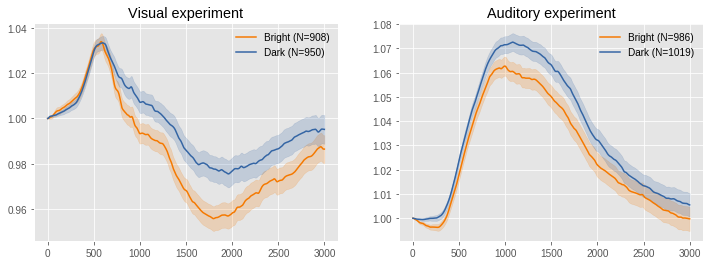

In [2]:
import sys
sys.argv.append('--visual')
from matplotlib import pyplot as plt
from analysis import pupil

plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title('Visual experiment')
pupil.brightness_plot(dm_visual, subplot=True)
plt.subplot(122)
plt.title('Auditory experiment')
pupil.brightness_plot(dm_auditory, subplot=True)
plt.show()

## Plot data for individual participants and words

Our experiment contains two random effects (i.e. things that we vary but we assume have no systematic effect): participant and word. To get an idea of how robust the pupil-size difference between darkness- and brightness-conveying words is, we plot the effect per participant (top row); and we plot pupil size for each word, as rank-ordered lines separately for darkness- and brightness-conveying words (bottom row).

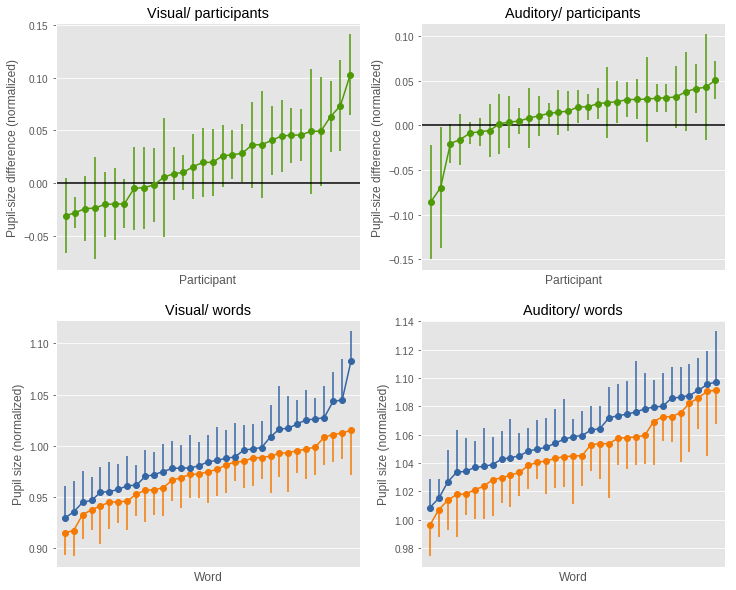

In [3]:
pupil.EXP = 'dummy'  # Ugly hack
plt.figure(figsize=(12,10))
plt.subplot(221)
plt.title('Visual/ participants')
pupil.subject_summary(dm_visual, save=False)
plt.subplot(222)
plt.title('Auditory/ participants')
pupil.subject_summary(dm_auditory, save=False)
plt.subplot(223)
plt.title('Visual/ words')
pupil.word_summary(dm_visual, save=False)
plt.subplot(224)
plt.title('Auditory/ words')
pupil.word_summary(dm_auditory, save=False)
plt.show()

## Control experiment

We also conducted a control experiment to show that differences in valence (positive v negative) do not affect pupil size, at least not when they are of equal emotional intensity. This is important, because the brightness-conveying words in our main experiments were rated as more positive than the darkness-conveying words (in a separate rating experiment, not shown here). 

The left figure below shows that valence does not notably affect pupil size. The right figure shows that emotional intensity does affect pupil size quite strongly. (Caveat: Positive and negative words were matched on important properties, but high and low intensity words were not.)

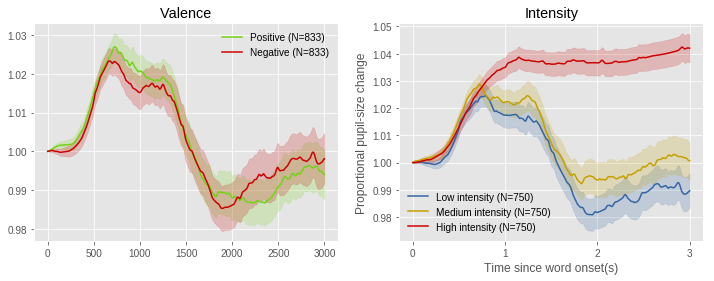

In [4]:
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.title('Valence')
pupil.valence_plot(dm_control, subplot=True)
plt.subplot(122)
plt.title('Intensity')
pupil.intensity_plot(dm_control, subplot=True)
plt.show()

## Flatten data

Convert the `SeriesColumn`s into duplicate rows for processing in other software that doesn't work with series.

In [5]:
from datamatrix import (
    DataMatrix,
    FloatColumn,
    IntColumn,
    io,
    series as srs,
    operations as ops
)


def flatten(dm, s):
    
    name = s.name
    dm = ops.keep_only(
        dm,
        'correct',
        'pupil',
        'rating_brightness',
        'rating_intensity',
        'rating_valence',
        'response_time',
        'response',
        'subject_nr',
        'type',
        'category',
        'word',
        name
    )    
    dm[name] = srs.downsample(dm[name], 10)
    depth = dm[name].depth
    fdm = DataMatrix(length=len(dm) * depth)
    for colname, col in dm.columns:
        if hasattr(col, 'depth'):
            continue
        fdm[colname] = col.__class__
    fdm[name] = FloatColumn
    fdm.pupil_time = IntColumn
    i = 0
    for row in dm:
        for colname, col in dm.columns:
            if hasattr(col, 'depth'):
                continue
            fdm[colname][i:i+depth] = row[colname]
        fdm[name][i:i+depth] = row[name]
        fdm.pupil_time[i:i+depth] = range(depth)
        i += depth
    return fdm

In [6]:
fdm_visual = flatten(dm_visual, dm_visual.pupil)
io.writetxt(fdm_visual, u'flat-visual.csv')
fdm_auditory = flatten(dm_auditory, dm_auditory.pupil)
io.writetxt(fdm_auditory, u'flat-auditory.csv')
fdm_control = flatten(dm_control, dm_control.pupil)
io.writetxt(fdm_control, u'flat-control.csv')